# Linear Regression from Scratch in PyTorch


Linear Regression is a foundational tool in the field of machine learning and statistics, used for predicting a continuous target variable based on one or more predictor variables. This guide delves into implementing linear regression in PyTorch, a leading deep learning library.

## Theoretical Background

Linear regression models the relationship between a dependent variable, `y`, and one or more independent variables, `X`, as a linear function:

$ y = Xw + b + \epsilon $

- $X$ represents the independent variables (features).
- $w$ is a weight matrix corresponding to the coefficients of the features.
- $b$ is the bias term, an intercept in the linear equation.
- $\epsilon$ is the error term, capturing the deviation of the predictions from the actual values.

The goal of linear regression is to find the optimal $w$ and $b$ that minimize the difference between predicted and actual values, typically using the Mean Squared Error (MSE) loss function:

$ \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $

Here, $y_i$ is the actual value, and $\hat{y}_i$ is the predicted value for the ith instance.

## Setup

In [1]:
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from src.data import DataLoaderScratch
from src.trainer import TrainerScratch
from src.optimizers import SGDScratch

## Data Preparation

### Synthetic Data Generation

We generate synthetic data to mimic a real-world linear relationship, adding Gaussian noise to simulate real-world data imperfections. This data serves as a playground to test our regression models.

In [2]:
n = 1000
w = torch.tensor([2, -3.4]).reshape((-1, 1))
b = 4

X = torch.randn(n, len(w))
noise = torch.normal(mean=0, std=0.01, size=(n, 1))
y = X @ w + b + noise

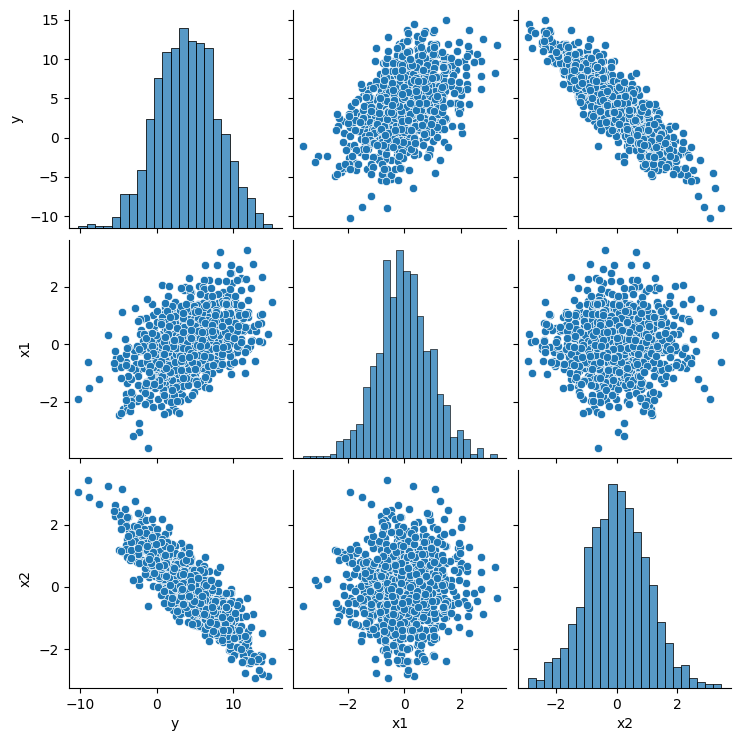

In [3]:
df = pd.DataFrame(torch.cat([y.reshape(-1, 1), X], dim=1), columns=["y", "x1", "x2"])
sns.pairplot(df)

### Data Splitting

The data is split into training and validation sets. The training set is used to train the model, and the validation set is used to evaluate its performance. This split helps in detecting overfitting and underfitting.

In [4]:
def train_test_split(X, y, train_size=0.8):
    # Shuffle the indices
    indices = torch.randperm(len(X)).tolist()

    # Calculate the number of samples in the training set
    train_size = int(train_size * len(X))

    # Slice the tensors to create training and validation sets
    X_train, y_train = X[indices[:train_size]], y[indices[:train_size]]
    X_val, y_val = X[indices[train_size:]], y[indices[train_size:]]

    return X_train, y_train, X_val, y_val

In [5]:
X_train, y_train, X_val, y_val = train_test_split(X, y, train_size=0.8)
train_dataloader = DataLoaderScratch(X_train, y_train, batch_size=64, shuffle=True)
val_dataloader = DataLoaderScratch(X_val, y_val, batch_size=64, shuffle=False)

## Linear Regression from Scratch

### Single Batch Iteration

In [6]:
in_features = X_train.shape[1]
num_samples = X_train.shape[0]
batch_size = 512

# Initialize weights
w = torch.randn(in_features, 1, requires_grad=True)
b = torch.zeros(1, 1, requires_grad=True)

parameters = [w, b]
optimizer = SGDScratch(parameters, lr=0.1)

# Create a batch
X_batch = X_train[: batch_size]
y_batch = y_train[: batch_size]

In [7]:
# Zero gradients
optimizer.zero_grad()

# Forward pass (training)
y_pred = X_batch @ w + b

# Calculate Loss
def mse_loss(y_pred, y): 
    loss = torch.mean((y - y_pred) ** 2)
    return loss

loss = mse_loss(y_pred, y_batch)
# Backward pass (compute gradients)
loss.backward()

# Update parameters
optimizer.step()

In [8]:
loss

tensor(23.2106, grad_fn=<MeanBackward0>)

### Define Training Loop and Model

In [9]:
class LinearRegressionScratch(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.w = torch.randn(in_features, 1, requires_grad=True)
        self.b = torch.zeros(1, 1, requires_grad=True)

    def forward(self, X):
        y_pred = X @ self.w + self.b
        return y_pred
    
    def parameters(self):
        return [self.w, self.b]

In [10]:
class MSELossScratch(nn.Module):
    def __init__(self):
        super(MSELossScratch, self).__init__()

    def forward(self, y_pred, y_true):
        loss = torch.mean((y_pred - y_true) ** 2)
        return loss


### Training the Model

Epoch 1/15, Training Loss: 33.7013, Validation Loss: 25.8202
Epoch 2/15, Training Loss: 19.5082, Validation Loss: 15.3134
Epoch 3/15, Training Loss: 11.5902, Validation Loss: 9.1015
Epoch 4/15, Training Loss: 6.9473, Validation Loss: 5.3851
Epoch 5/15, Training Loss: 4.1268, Validation Loss: 3.1917
Epoch 6/15, Training Loss: 2.4423, Validation Loss: 1.8925
Epoch 7/15, Training Loss: 1.4371, Validation Loss: 1.1291
Epoch 8/15, Training Loss: 0.8604, Validation Loss: 0.6734
Epoch 9/15, Training Loss: 0.5204, Validation Loss: 0.4001
Epoch 10/15, Training Loss: 0.3071, Validation Loss: 0.2393
Epoch 11/15, Training Loss: 0.1851, Validation Loss: 0.1422
Epoch 12/15, Training Loss: 0.1108, Validation Loss: 0.0845
Epoch 13/15, Training Loss: 0.0675, Validation Loss: 0.0496
Epoch 14/15, Training Loss: 0.0391, Validation Loss: 0.0295
Epoch 15/15, Training Loss: 0.0233, Validation Loss: 0.0176


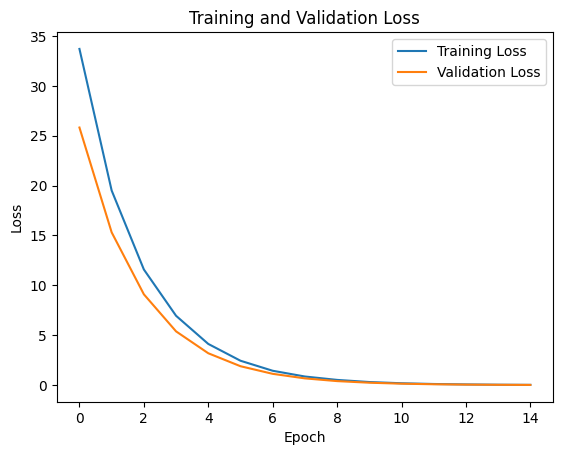

In [11]:
in_features = X_train.shape[1]
num_epochs = 15
learning_rate = 0.01

model = LinearRegressionScratch(in_features=in_features)
optimizer = SGDScratch(model.parameters(), lr=learning_rate)
criterion = MSELossScratch()
trainer = TrainerScratch(model, train_dataloader, val_dataloader, optimizer, criterion)
trainer.fit(num_epochs=num_epochs)

## Regularized Linear Regression From Scratch

Regularization is a technique to reduce overfitting. In `RegularizedLinearRegressionModel`, we add a regularization term to the loss function:

$ \text{Total Loss} = \text{MSE Loss} + \frac{\lambda}{2} \sum_{i=1}^{d} w_i^2 $

- $\lambda$ is the regularization strength.
- The regularization term penalizes large weights, encouraging simpler models.

In [12]:
n, d = 20, 200
X = torch.randn(n, d)
noise = torch.randn(n, 1) * 0.01
w, b = torch.ones((d, 1)) * 0.01, 0.05

1
y = torch.matmul(X, w) + b + noise

In [13]:
X_train, y_train, X_val, y_val = train_test_split(X, y, train_size=0.2)
train_dataloader = DataLoaderScratch(X_train, y_train, batch_size=64, shuffle=True)
val_dataloader = DataLoaderScratch(X_val, y_val, batch_size=64, shuffle=False)

We compare the performance of the regularized model with different $\lambda$ values to illustrate the effect of regularization.

In [14]:
class MSELossL2Scratch(nn.Module):
    def __init__(self, model, lambda_l2=0.01):
        super(MSELossL2Scratch, self).__init__()
        self.model = model
        self.lambda_l2 = lambda_l2

    def forward(self, y_pred, y_true):
        mse_loss = torch.mean((y_pred - y_true) ** 2)
        reg_loss = self.lambda_l2 * model.w.norm() ** 2 / 2
        total_loss = mse_loss + reg_loss
        return total_loss

Epoch 1/15, Training Loss: 121.7800, Validation Loss: 183.5867
Epoch 2/15, Training Loss: 3.1929, Validation Loss: 182.7506
Epoch 3/15, Training Loss: 0.1717, Validation Loss: 182.5392
Epoch 4/15, Training Loss: 0.0106, Validation Loss: 182.4743
Epoch 5/15, Training Loss: 0.0008, Validation Loss: 182.4544
Epoch 6/15, Training Loss: 0.0001, Validation Loss: 182.4482
Epoch 7/15, Training Loss: 0.0000, Validation Loss: 182.4463
Epoch 8/15, Training Loss: 0.0000, Validation Loss: 182.4457
Epoch 9/15, Training Loss: 0.0000, Validation Loss: 182.4456
Epoch 10/15, Training Loss: 0.0000, Validation Loss: 182.4455
Epoch 11/15, Training Loss: 0.0000, Validation Loss: 182.4454
Epoch 12/15, Training Loss: 0.0000, Validation Loss: 182.4454
Epoch 13/15, Training Loss: 0.0000, Validation Loss: 182.4454
Epoch 14/15, Training Loss: 0.0000, Validation Loss: 182.4454
Epoch 15/15, Training Loss: 0.0000, Validation Loss: 182.4454


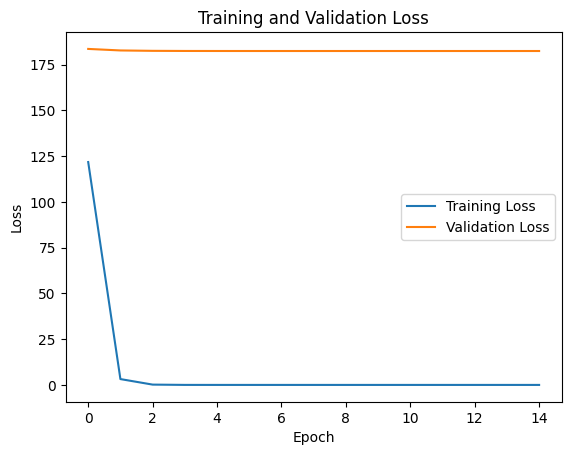

In [15]:
in_features = X_train.shape[1]
num_epochs = 15
learning_rate = 0.01
lambda_l2 = 0

model = LinearRegressionScratch(in_features=in_features)
optimizer = SGDScratch(model.parameters(), lr=learning_rate)
criterion = MSELossL2Scratch(model, lambda_l2=lambda_l2)
trainer = TrainerScratch(model, train_dataloader, val_dataloader, optimizer, criterion)
trainer.fit(num_epochs=num_epochs)

Epoch 1/15, Training Loss: 704.5038, Validation Loss: 546.3933
Epoch 2/15, Training Loss: 420.2705, Validation Loss: 494.6557
Epoch 3/15, Training Loss: 376.6284, Validation Loss: 446.2538
Epoch 4/15, Training Loss: 339.8366, Validation Loss: 402.7461
Epoch 5/15, Training Loss: 306.7003, Validation Loss: 363.4550
Epoch 6/15, Training Loss: 276.7971, Validation Loss: 327.9988
Epoch 7/15, Training Loss: 249.8095, Validation Loss: 295.9998
Epoch 8/15, Training Loss: 225.4531, Validation Loss: 267.1218
Epoch 9/15, Training Loss: 203.4715, Validation Loss: 241.0604
Epoch 10/15, Training Loss: 183.6331, Validation Loss: 217.5410
Epoch 11/15, Training Loss: 165.7290, Validation Loss: 196.3156
Epoch 12/15, Training Loss: 149.5705, Validation Loss: 177.1606
Epoch 13/15, Training Loss: 134.9875, Validation Loss: 159.8740
Epoch 14/15, Training Loss: 121.8263, Validation Loss: 144.2736
Epoch 15/15, Training Loss: 109.9483, Validation Loss: 130.1950


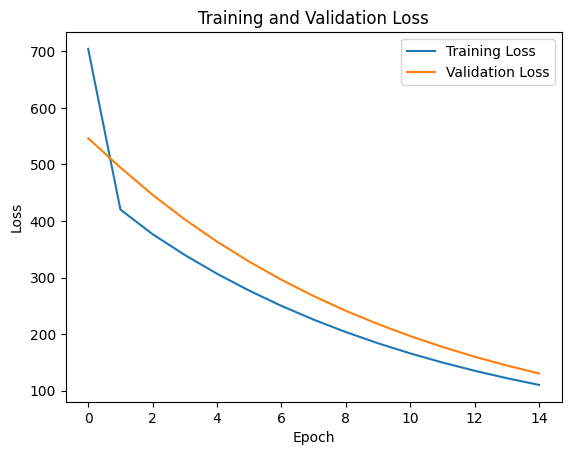

In [16]:
in_features = X_train.shape[1]
num_epochs = 15
learning_rate = 0.01
lambda_l2 = 5

model = LinearRegressionScratch(in_features=in_features)
optimizer = SGDScratch(model.parameters(), lr=learning_rate)
criterion = MSELossL2Scratch(model, lambda_l2=lambda_l2)
trainer = TrainerScratch(model, train_dataloader, val_dataloader, optimizer, criterion)
trainer.fit(num_epochs=num_epochs)

## Concise Implementation of Linear Regression with SGD

For a more concise implementation, we leverage PyTorch's built-in modules:

- **`nn.Linear`**: Defines a linear layer with weights and biases.
- **`optim.SGD`**: Stochastic Gradient Descent optimizer.
- **`nn.MSELoss`**: Mean Squared Error loss function.

These functions abstract away much of the manual work, allowing for a more streamlined and error-free implementation.

In [17]:
n = 1000
w = torch.tensor([2, -3.4]).reshape((-1, 1))
b = 4

X = torch.randn(n, len(w))
noise = torch.normal(mean=0, std=0.01, size=(n, 1))
y = X @ w + b + noise

Epoch 1/10, Training Loss: 22.1046, Validation Loss: 16.3328
Epoch 2/10, Training Loss: 12.9469, Validation Loss: 9.5731
Epoch 3/10, Training Loss: 7.6639, Validation Loss: 5.5747
Epoch 4/10, Training Loss: 4.4420, Validation Loss: 3.2567
Epoch 5/10, Training Loss: 2.6077, Validation Loss: 1.8964
Epoch 6/10, Training Loss: 1.5143, Validation Loss: 1.1075
Epoch 7/10, Training Loss: 0.8864, Validation Loss: 0.6467
Epoch 8/10, Training Loss: 0.5157, Validation Loss: 0.3783
Epoch 9/10, Training Loss: 0.3020, Validation Loss: 0.2211
Epoch 10/10, Training Loss: 0.1758, Validation Loss: 0.1298


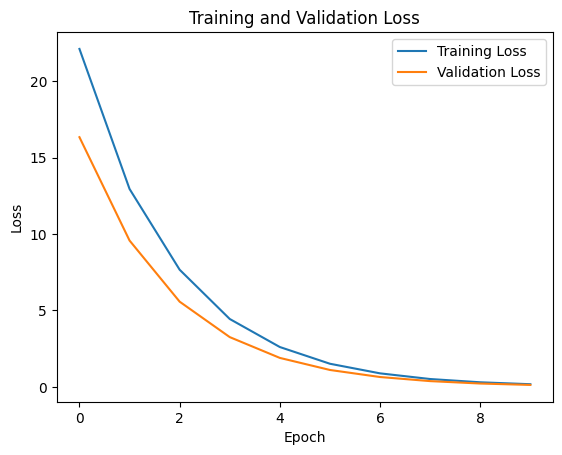

In [18]:
# Assuming X and y are your feature and target tensors
# Split Data into Train and Test Sets
dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Define DataLoader
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Define the Linear Regression Model
class LinearRegression(nn.Module):
    def __init__(self, input_size):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)


model = LinearRegression(X.shape[1])

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
trainer = TrainerScratch(model, train_dataloader, val_dataloader, optimizer, criterion)
trainer.fit(num_epochs=10)

In [20]:
model.linear.weight

Parameter containing:
tensor([[ 1.8562, -3.2038]], requires_grad=True)